### The Joker

Alternative means of blind RV search using Adrian Price-Whelan's code

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.8
exoplanet version: 0.2.4
scipy version: 1.4.1


In [3]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.coordinates as coord
import astropy.table as at
from astropy.time import Time

import pymc3 as pm
import exoplanet.units as xu
import thejoker as tj

In [4]:
np.random.seed(42)

In [5]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [6]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

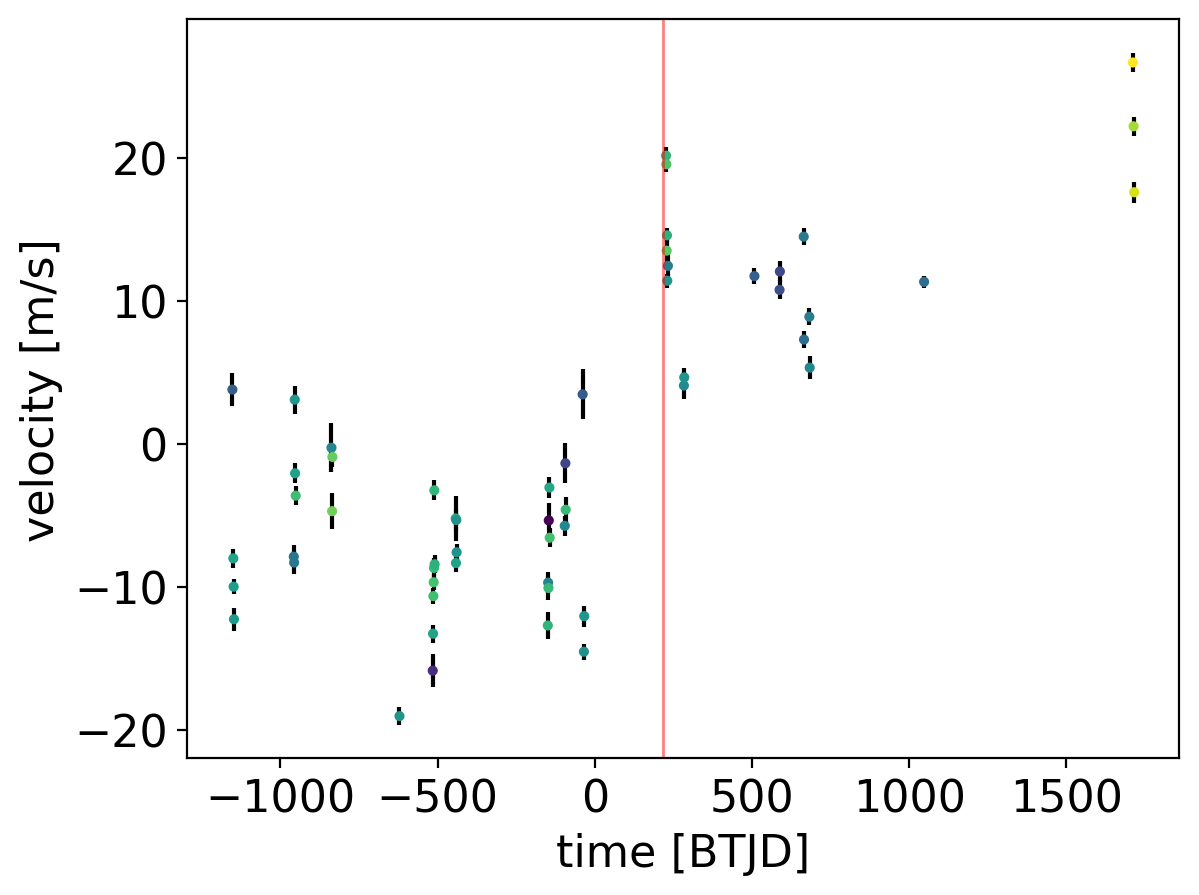

In [7]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray(df.bis, dtype=np.float64)
fwhm_rv = np.ascontiguousarray(df.fwhm, dtype=np.float64)
shk = np.ascontiguousarray(df.s_hk, dtype=np.float64)
yerr_shk = np.ascontiguousarray(df.e_s_hk, dtype=np.float64)



t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv, y_rv, c=shk, s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

In [8]:
# split data into pre/post upgrade:
data1 = tj.RVData(t=Time(x_rv[~pug], format='jd', scale='tcb'), 
                  rv=y_rv[~pug] * u.m/u.s,
                  rv_err=yerr_rv[~pug] * u.m/u.s)
data2 = tj.RVData(t=Time(x_rv[pug], format='jd', scale='tcb'), 
                  rv=y_rv[pug] * u.m/u.s,
                  rv_err=yerr_rv[pug] * u.m/u.s)
data = [data1, data2]

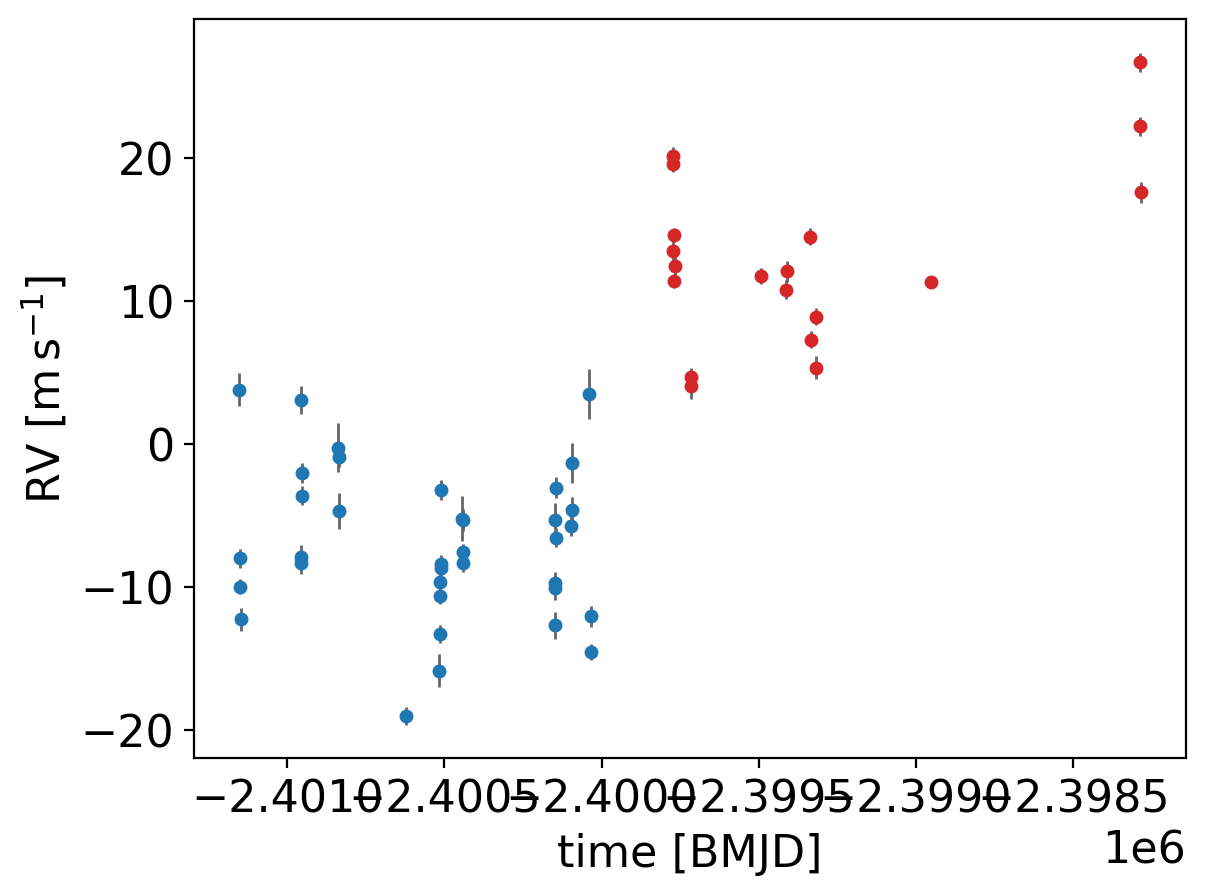

In [9]:
for d, color in zip([data1, data2], ['tab:blue', 'tab:red']):
    _ = d.plot(color=color, ms=4)

#### run the Joker(TM):

In [10]:
with pm.Model() as model:
    # Parameter representing the offset between pre/post upgrade
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 15.4, 5.), 
                         u.m/u.s)
    
    # Allow extra error to account for under-estimated error bars
    s = xu.with_unit(pm.Lognormal('s', 0.5, 1.5),
                     u.m/u.s)
    
    # Force the eccentricity to be 0
    e = xu.with_unit(pm.Constant('e', 0),
                     u.one)

    prior = tj.JokerPrior.default(
        P_min=8*u.day, P_max=32*u.day,
        sigma_K0=10*u.m/u.s,
        sigma_v=[5*u.m/u.s,
                 0.1*u.m/u.s/u.day,
                 1e-2*u.m/u.s/u.day**2],
        poly_trend=3,
        v0_offsets=[dv0_1],
        s=s,
        pars={'e': e})

In [11]:
prior_samples = prior.sample(size=4_000_000)

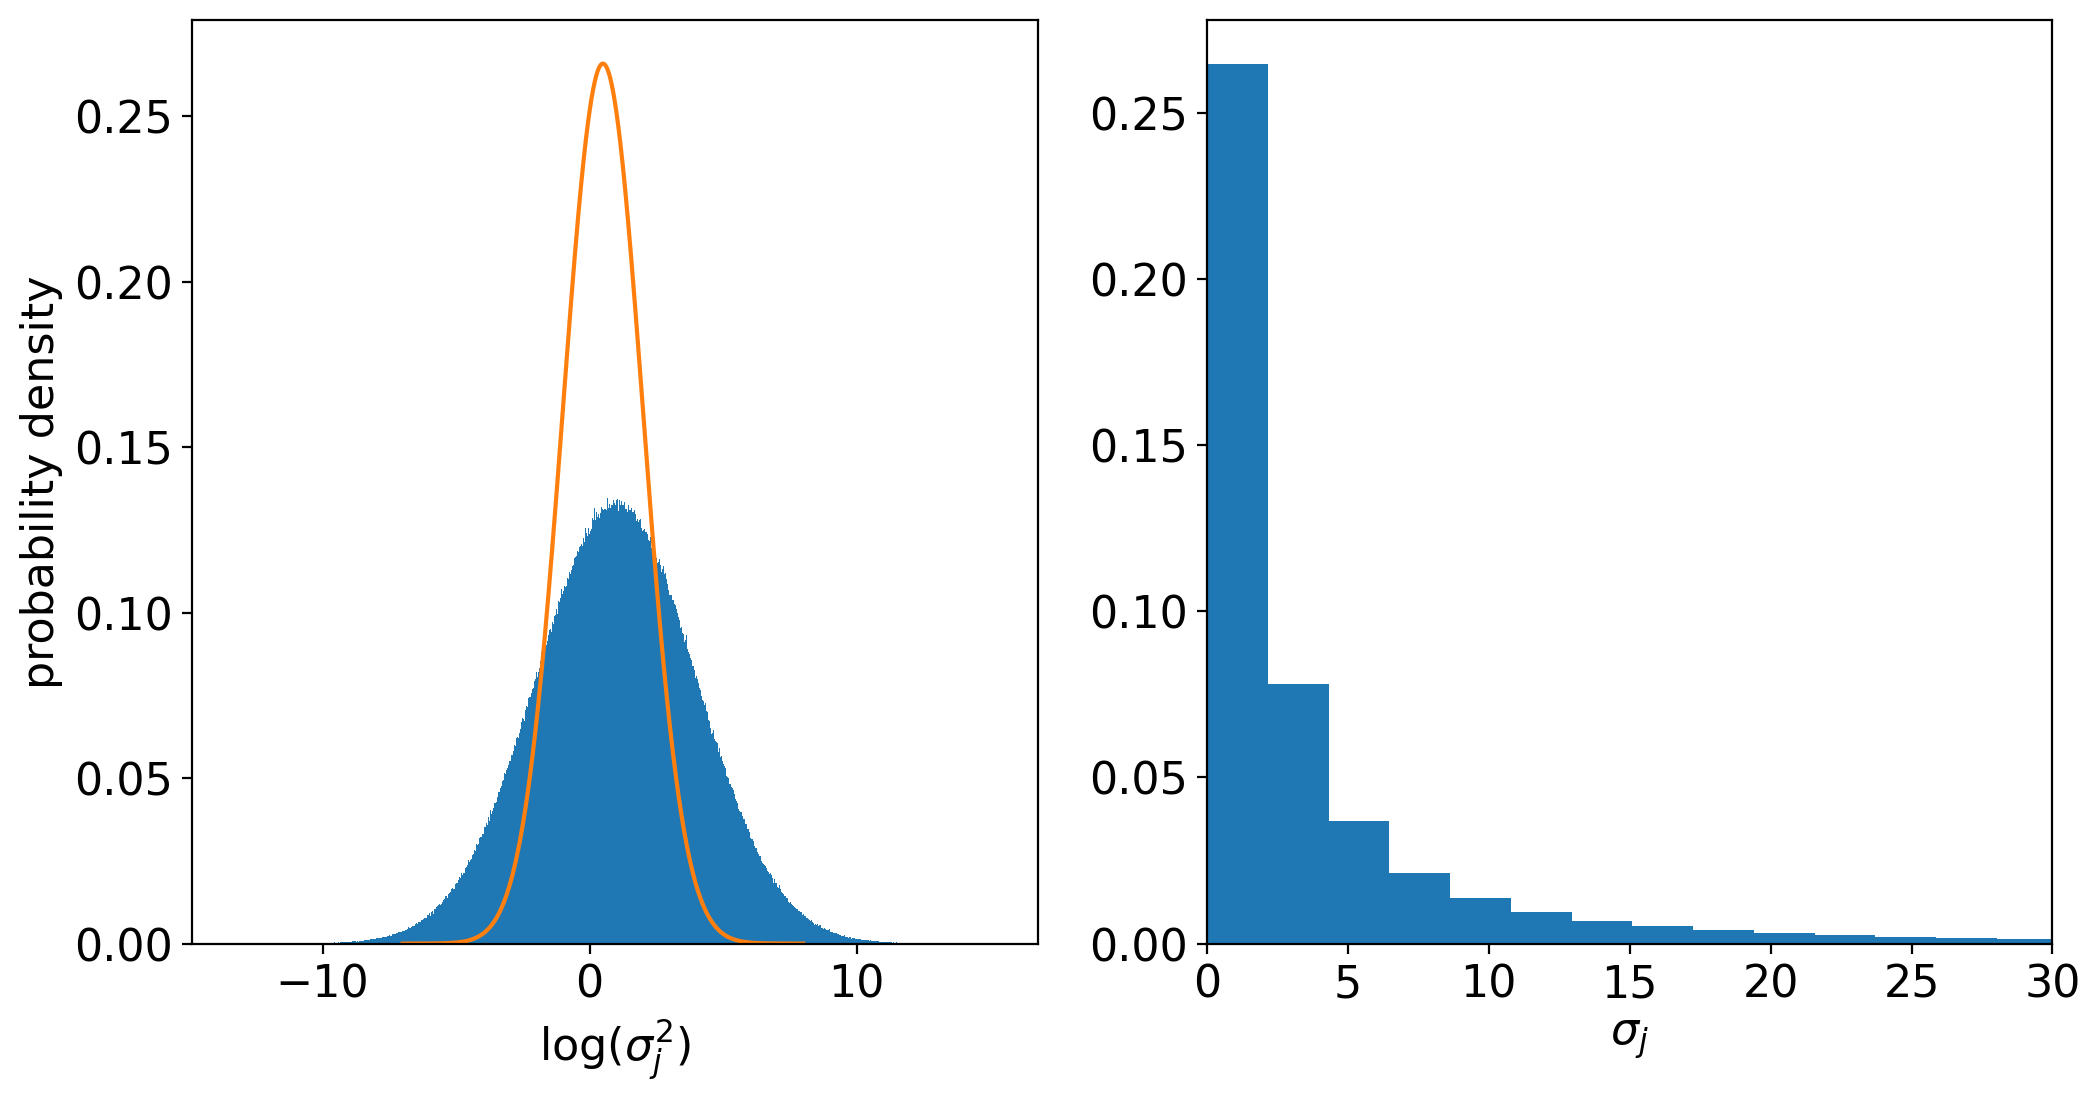

In [14]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(np.log(prior_samples['s'].value)*2., bins=1000, density=True)
xx = np.linspace(-7,8,1000)
mu, sig = 0.5, 1.5
yy = np.exp(-(xx-mu)**2 / (2 * sig**2)) / np.sqrt(2*np.pi*sig**2)
ax1.plot(xx, yy)
ax1.set_xlabel(r'log($\sigma_j^2$)')
ax1.set_ylabel('probability density')
ax2.hist(prior_samples['s'].value, bins=1000, density=True)
ax2.set_xlim([0.,30.])
ax2.set_xlabel(r'$\sigma_j$');

In [15]:
%%time
joker = tj.TheJoker(prior)
joker_samples = joker.rejection_sample(data, prior_samples,
                                       max_posterior_samples=128)

CPU times: user 2h 41min 38s, sys: 1min 39s, total: 2h 43min 17s
Wall time: 45min 15s


In [16]:
joker_samples['dv0_1'], joker_samples['P']

(<Quantity [25.62585611, 25.425281  , 25.18679796, 24.96336285, 26.15366776,
            25.52006868, 24.9432367 , 25.11737671, 24.63747154, 24.84858477] m / s>,
 <Quantity [8.68398074, 8.68355026, 8.68395745, 8.68305807, 8.68383875,
            8.68317373, 8.6851524 , 8.68413529, 8.68247983, 8.6828982 ] d>)

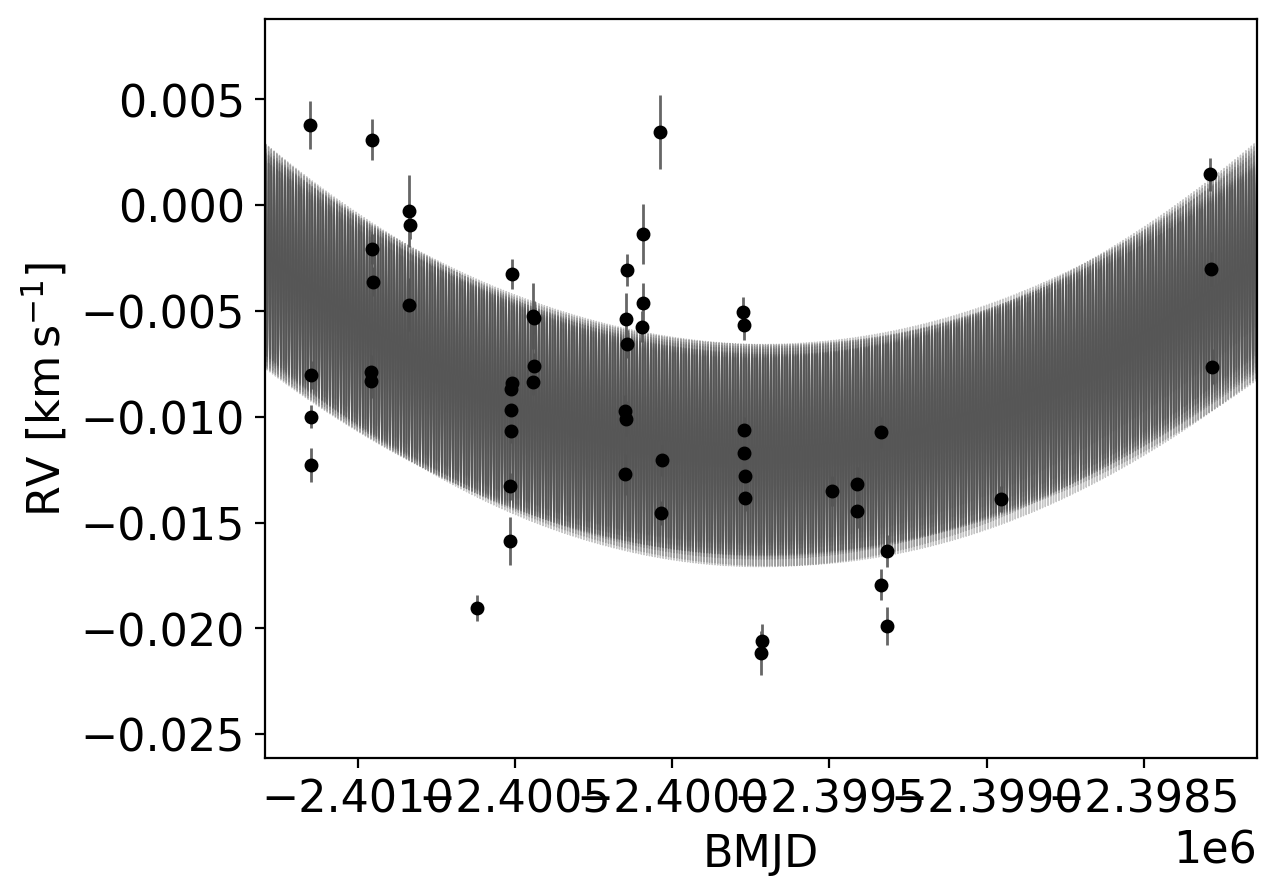

In [17]:
_ = tj.plot_rv_curves(joker_samples, data=data)

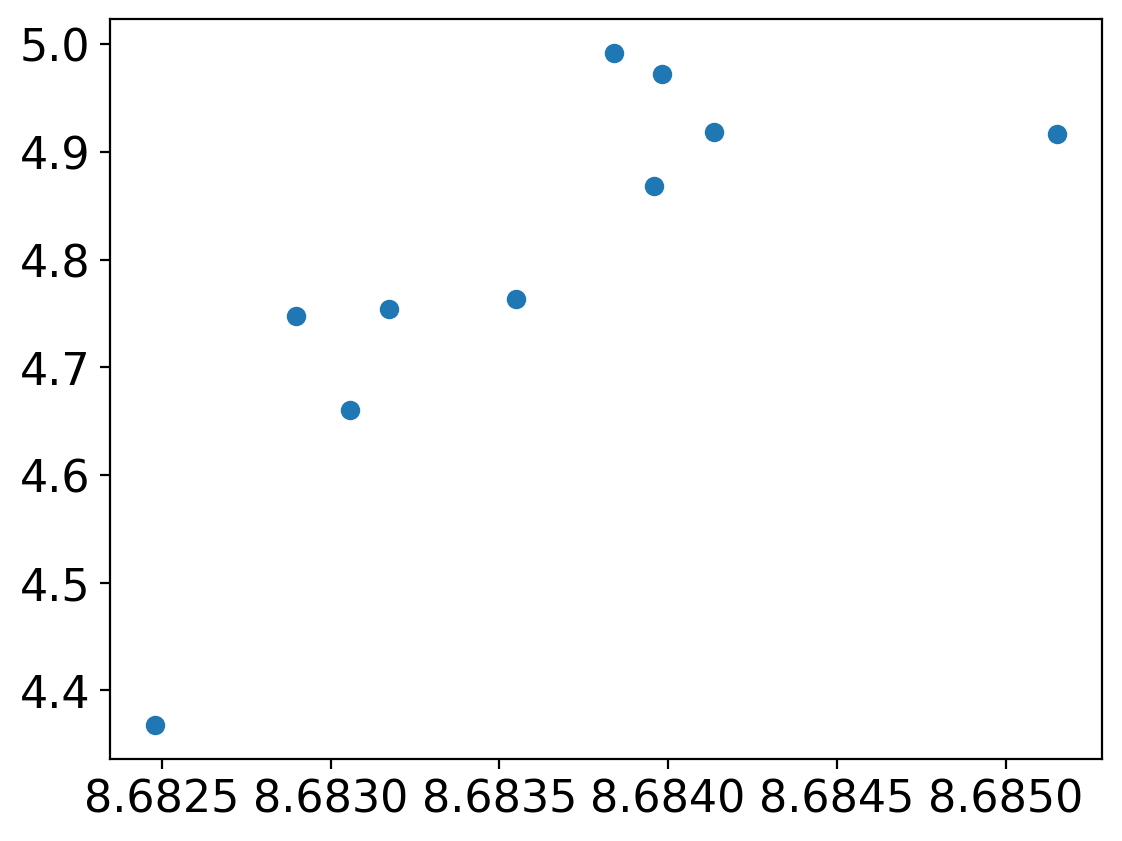

In [18]:
plt.scatter(joker_samples['P'].to_value(u.day), 
            np.abs(joker_samples['K'].to_value(u.m/u.s)))

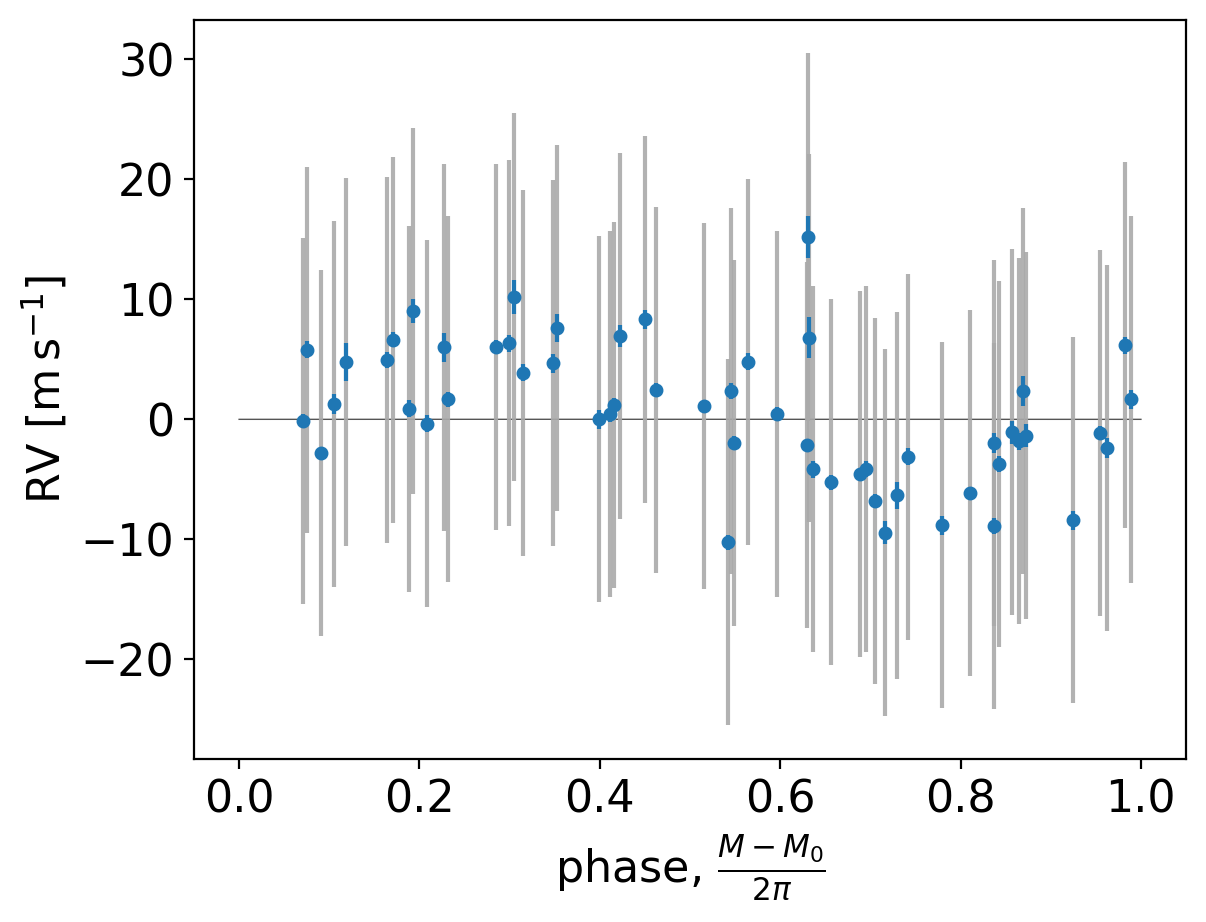

In [19]:
_ = tj.plot_phase_fold(joker_samples[0], data=data)